# Used Car Prices CarGurus: LinearSVR GPU
## Optuna Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RAPIDS/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [805 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd

In [ ]:
# Install CondaColab and restart the kernel
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:30
🔁 Restarting kernel...


In [ ]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [ ]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
import os
import random
import time
from contextlib import contextmanager
import dask
import dask_optuna
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait, performance_report
import joblib
from joblib import parallel_backend
import numpy as np
import cupy as cp
import cudf
import cuml
from cuml.model_selection import train_test_split
from cuml.svm import LinearSVR
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import pickle
import pandas as pd
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
my_dpi = 96
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.4 MB/s 
     |████████████████████████████████| 1.6 MB 20.7 MB/s 
     |████████████████████████████████| 81 kB 11.2 MB/s 
     |████████████████████████████████| 209 kB 94.0 MB/s 
     |████████████████████████████████| 150 kB 75.0 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 112 kB 71.2 MB/s 
     |████████████████████████████████| 146 kB 52.7 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1ef9518d9a543a8f4779d25ac675c1a8461bd14a6c7ba183535e7c1e4cef8ade
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [ ]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', 
                           dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

/usr/local/lib/python3.7/site-packages/distributed/client.py:1131: VersionMismatchWarning:

Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+



Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://172.28.0.2:8081/status,
Dashboard: http://172.28.0.2:8081/status,Workers: 1
Total threads: 1,Total memory: 25.46 GiB
Status: running,Using processes: True
Comm: tcp://172.28.0.2:42583,Workers: 1
Dashboard: http://172.28.0.2:8081/status,Total threads: 1
Started: Just now,Total memory: 25.46 GiB
Comm: tcp://172.28.0.2:45561,Total threads: 1
Dashboard: http://172.28.0.2:45037/status,Memory: 25.46 GiB
Nanny: tcp://172.28.0.2:40335,


In [ ]:
# Set seed 
seed_value = 42
os.environ['SVR_GPU'] = str(seed_value)
random.seed(seed_value)
cp.random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [ ]:
# Read data
df = cudf.read_csv('usedCars_final.csv')
print('Number of rows and columns:', df.shape)

Number of rows and columns: (327912, 28)


In [ ]:
# Find categorical variables
cat_cols = list(df.select_dtypes('object').columns)

# Set up features and target
X, y = df.drop(['price'], axis=1), df['price'].astype('float32')

## 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_optuna_linearsvr_100_rmse_tpe'

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l2', 
                   loss='epsilon_insensitive', 
                   penalized_intercept='False', 
                   max_iter=10000, 
                   linesearch_max_iter=100, 
                   lbfgs_memory=5, C=10, 
                   grad_tol=0.0001, change_tol=1e-5, 
                   epsilon=0.1, verbose=False): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: RMSE of the fitted model
    """
    # Prepare the data for modeling
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        random_state=42)
    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')
    X_test = cudf.get_dummies(X_test, columns=cat_cols)
    X_test = X_test.astype('float32')

    # Define model
    model = LinearSVR(penalty=penalty,
                      loss=loss, 
                      penalized_intercept=penalized_intercept, 
                      max_iter=max_iter, 
                      linesearch_max_iter=linesearch_max_iter, 
                      lbfgs_memory=lbfgs_memory, 
                      C=C, 
                      grad_tol=grad_tol, 
                      change_tol=change_tol, 
                      epsilon=epsilon, 
                      verbose=False)  
    
    # Start timer for each trial
    start = timer()

    # Fit model
    model.fit(X_train, y_train)
    run_time = timer() - start

    # Predict on the model
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test.to_numpy(), y_pred.to_numpy(), 
                               squared=False)
    print('- Trial RMSE:', score)
    
    return score

In [ ]:
# Fit model with default parameters
print('Score with default parameters : ', train_and_eval(X, y))

- Trial RMSE: 5575.6704
Score with default parameters :  5575.6704


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'LinearSVR_Optuna_100_GPU.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['squared_epsilon_insensitive', 
                                              'epsilon_insensitive']) 
    penalized_intercept = trial.suggest_categorical('penalized_intercept', 
                                                    ['True', 'False'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 100, 10000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 5, 20) 
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-3, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-53, 1e-3) 
    epsilon = trial.suggest_float('epsilon', 0.1, 1, step=0.1) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss=loss, 
                           penalized_intercept=penalized_intercept, 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           epsilon=epsilon, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVR_Optuna_100_GPU.pkl'): 
      study = joblib.load('LinearSVR_Optuna_100_GPU.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='minimize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X, y), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest RMSE', study.best_value)

Start Time           2022-06-06 23:34:47.347103
[W] [23:34:47.679183] QWL-QN line search failed (code 1); stopping at the last valid step
- Trial RMSE: 17077.451
- Trial RMSE: 7474.9746
[W] [23:34:48.054630] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial RMSE: 26198.95
- Trial RMSE: 8820.484
- Trial RMSE: 17191.549
- Trial RMSE: 7461.0444
[W] [23:34:48.796472] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial RMSE: 26198.955
[W] [23:34:48.967308] L-BFGS line search failed (code 4); stopping at the last valid step
- Trial RMSE: 26198.938
- Trial RMSE: 16722.59
- Trial RMSE: 8820.968
- Trial RMSE: 7458.2056
- Trial RMSE: 7458.2056
- Trial RMSE: 6529.4834
- Trial RMSE: 6529.886
- Trial RMSE: 5581.8745
- Trial RMSE: 7457.4844
- Trial RMSE: 5636.8687
- Trial RMSE: 7457.4844
- Trial RMSE: 7457.1685
- Trial RMSE: 5639.662
- Trial RMSE: 7391.309
- Trial RMSE: 5638.886
- Trial RMSE: 5632.0586
- Trial RMSE: 6526.5356
- Trial RMSE: 7390.287
-

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'rmse'},inplace=True)
trials_df.rename(columns={'params_C': 'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol': 'change_tol'}, inplace=True)
trials_df.rename(columns={'params_epsilon': 'epsilon'}, inplace=True)
trials_df.rename(columns={'params_grad_tol': 'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory': 'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter': 'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_loss': 'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter': 'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept': 'penalized_intercept'}, 
                 inplace=True)
trials_df.rename(columns={'params_penalty': 'penatly'}, inplace=True)
trials_df = trials_df.sort_values('rmse', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('LinearSVR_Optuna_100_GPU.csv', index=False)

    iteration          rmse             datetime_start  \
74         74   4910.110352 2022-06-06 23:35:10.948578   
51         51   4921.295898 2022-06-06 23:35:00.053788   
89         89   4922.517578 2022-06-06 23:35:20.632134   
48         48   4923.411133 2022-06-06 23:34:58.907693   
90         90   4923.411133 2022-06-06 23:35:21.337358   
..        ...           ...                        ...   
4           4  17191.548828 2022-06-06 23:34:48.261630   
7           7  26198.937500 2022-06-06 23:34:48.821303   
38         38  26198.945312 2022-06-06 23:34:56.161048   
2           2  26198.949219 2022-06-06 23:34:47.907051   
6           6  26198.955078 2022-06-06 23:34:48.658220   

            datetime_complete               duration     C  change_tol  \
74 2022-06-06 23:35:11.617111 0 days 00:00:00.668533  10.0    0.000747   
51 2022-06-06 23:35:00.626606 0 days 00:00:00.572818   8.2    0.000455   
89 2022-06-06 23:35:21.337208 0 days 00:00:00.705074   9.3    0.000593   
48 2022

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'epsilon',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVR_Optuna_100_GPU.html')
fig.show() 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/trialOptions


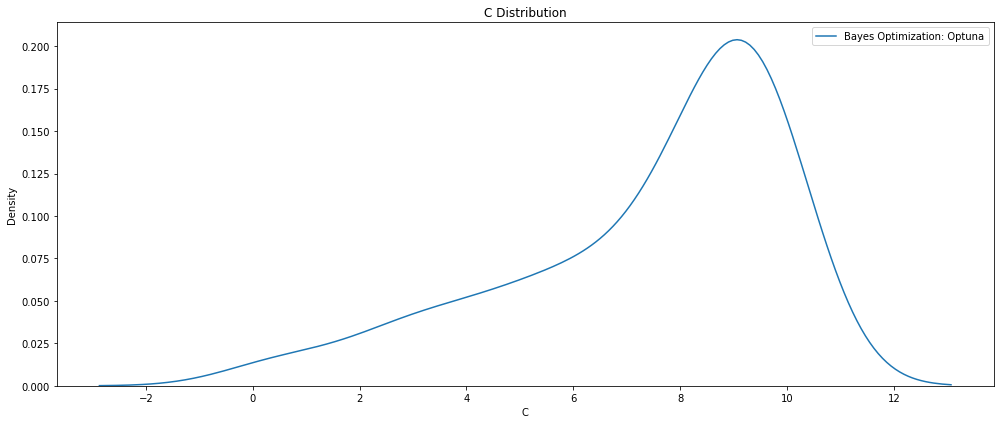

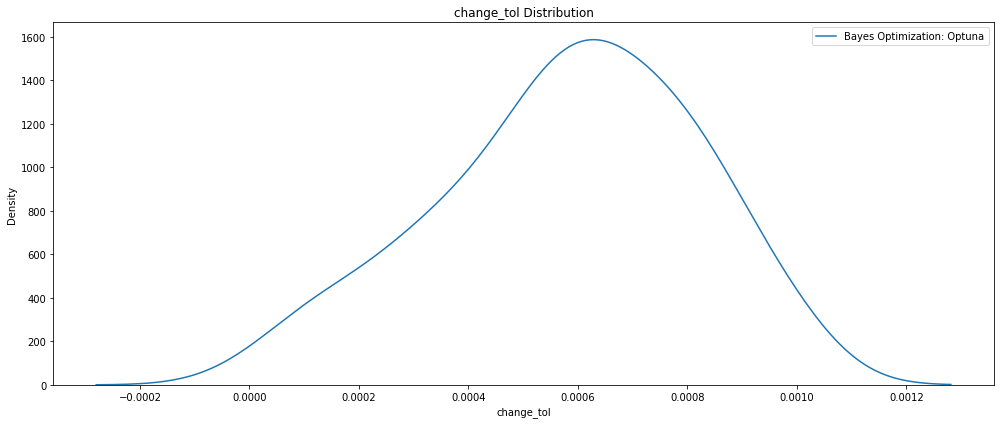

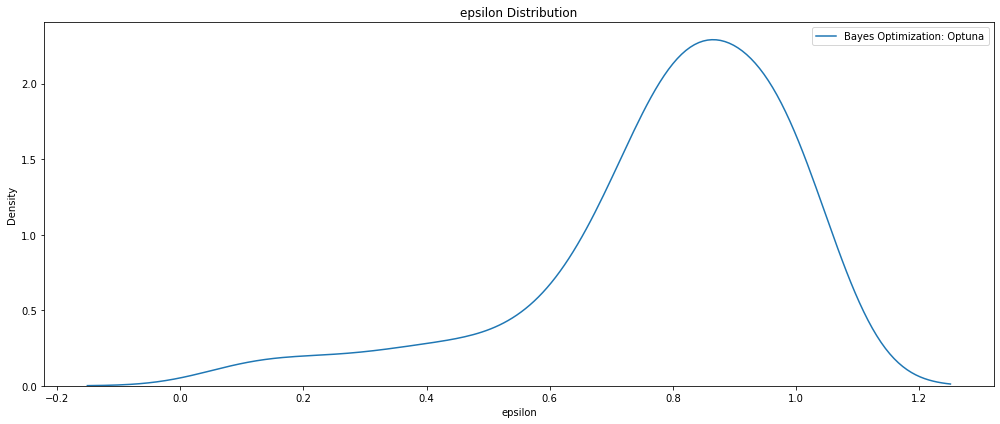

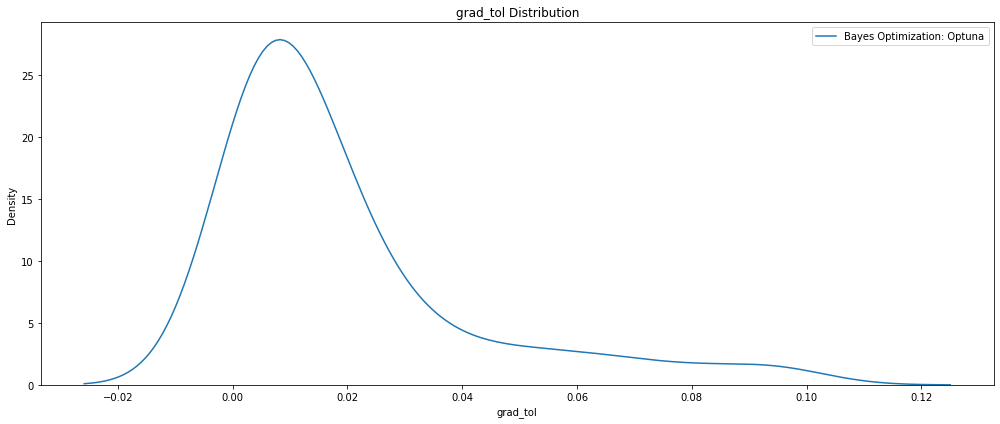

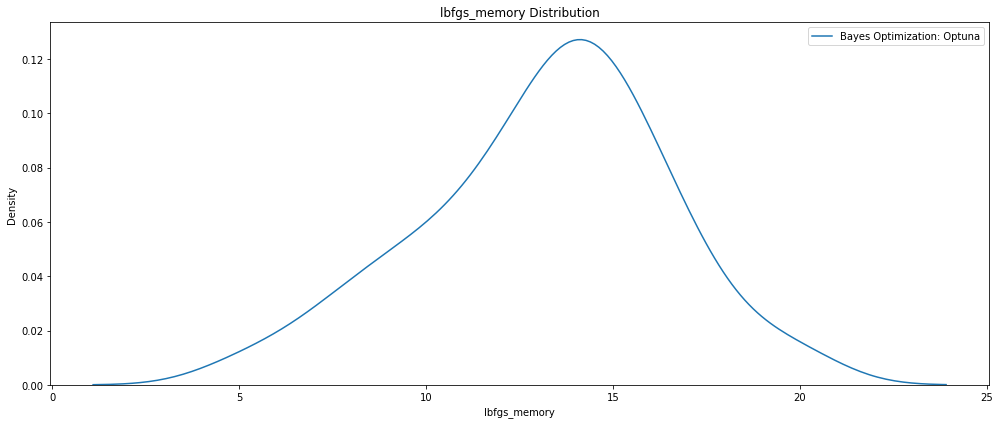

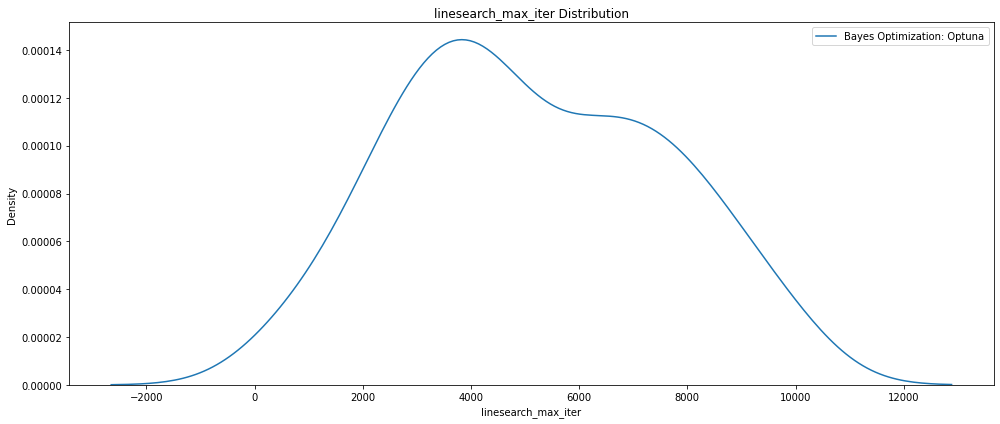

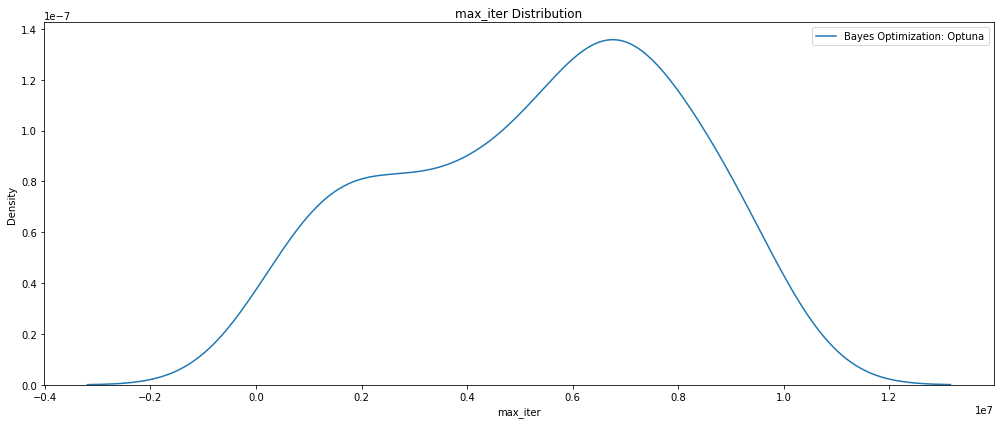

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

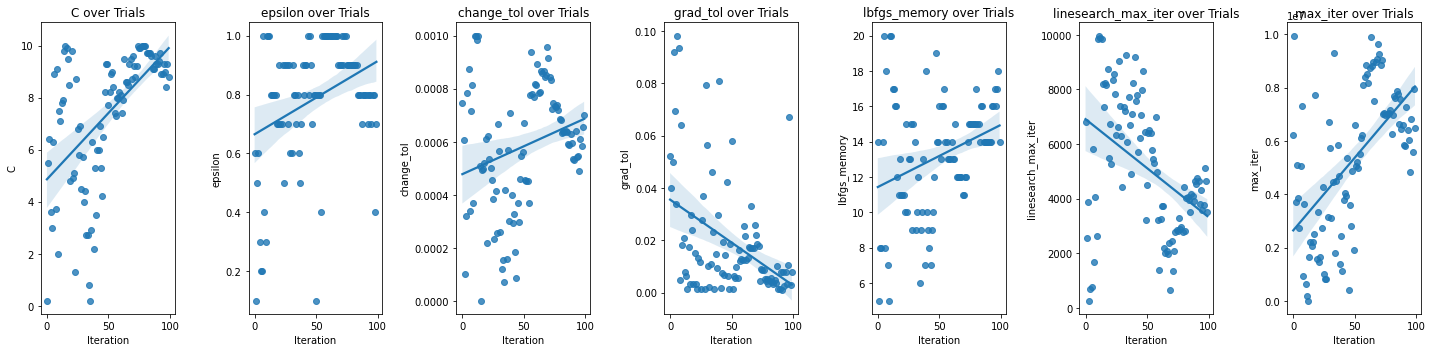

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 7, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'epsilon', 'change_tol', 
                         'grad_tol', 'lbfgs_memory', 
                         'linesearch_max_iter', 'max_iter']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVR_Optuna_100_GPU.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 10.0,
 'change_tol': 0.000746569583741204,
 'epsilon': 1.0,
 'grad_tol': 0.00885389506766314,
 'lbfgs_memory': 15,
 'linesearch_max_iter': 2861,
 'loss': 'epsilon_insensitive',
 'max_iter': 7035104,
 'penalized_intercept': 'True',
 'penalty': 'l1'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=seed_value)

In [ ]:
# Create dummy variables and convert data type for modeling
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

X_test = cudf.get_dummies(X_test, columns=cat_cols)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVR(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVR_Optuna_trials100_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVR_Optuna_trials100_GPU')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for LinearSVR HPO 100 GPU trials')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_absolute_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy(), 
                           squared=False),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy(), 
                           squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train.to_numpy(), y_train_pred.to_numpy()),
        r2_score(y_test.to_numpy(), y_test_pred.to_numpy())))


Model Metrics for LinearSVR HPO 100 GPU trials
MAE train: 3734.131, test: 3732.142
MSE train: 24207284.000, test: 24109184.000
RMSE train: 4920.090, test: 4910.110
R^2 train: 0.736, test: 0.736


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test.to_numpy(), 
                                                                                                      y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 24109184.00000 MSE on the test set.
This was achieved using these conditions:
iteration                                      74
rmse                                  4910.110352
datetime_start         2022-06-06 23:35:10.948578
datetime_complete      2022-06-06 23:35:11.617111
duration                   0 days 00:00:00.668533
C                                            10.0
change_tol                               0.000747
epsilon                                       1.0
grad_tol                                 0.008854
lbfgs_memory                                   15
linesearch_max_iter                          2861
loss                          epsilon_insensitive
max_iter                                  7035104
penalized_intercept                          True
penatly                                        l1
state                                    COMPLETE
Name: 0, dtype: object


## 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL/

# Define a name for the trials
study_name = 'dask_optuna_linearsvr_1000_rmse_tpe'

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'LinearSVR_Optuna_1000_GPU.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    max_iter = trial.suggest_int('max_iter', -1, 10e6)
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 2000, 3000)  
    lbfgs_memory = trial.suggest_int('lbfgs_memory', 10, 25) 
    C = trial.suggest_float('C', 7, 15, step=0.1)
    grad_tol = trial.suggest_float('grad_tol', 1e-4, 1e-1)
    change_tol = trial.suggest_float('change_tol', 1e-4, 1e-1) 
    epsilon = trial.suggest_float('epsilon', 0.7, 1.5, step=0.1) 

    score = train_and_eval(X_param,
                           y_param,
                           penalty=penalty, 
                           loss='epsilon_insensitive', 
                           penalized_intercept='True', 
                           max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           lbfgs_memory=lbfgs_memory, 
                           C=C, 
                           grad_tol=grad_tol, 
                           change_tol=change_tol, 
                           epsilon=epsilon, 
                           verbose=False)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('LinearSVR_Optuna_1000_GPU.pkl'): 
      study = joblib.load('LinearSVR_Optuna_1000_GPU.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='minimize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X, y), 
                       n_trials=1000,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest RMSE', study.best_value)

Start Time           2022-06-07 01:04:38.130901
- Trial RMSE: 5609.449
- Trial RMSE: 7458.206
- Trial RMSE: 7497.7124
- Trial RMSE: 8820.486
- Trial RMSE: 8820.497
- Trial RMSE: 7497.6284
- Trial RMSE: 7458.1816
- Trial RMSE: 7330.3677
- Trial RMSE: 7458.209
- Trial RMSE: 7497.489
- Trial RMSE: 5581.6167
- Trial RMSE: 5581.8657
- Trial RMSE: 5581.791
- Trial RMSE: 7458.0957
- Trial RMSE: 7397.0034
- Trial RMSE: 7457.1685
- Trial RMSE: 7397.0034
- Trial RMSE: 7458.0957
- Trial RMSE: 7396.5024
- Trial RMSE: 8668.958
- Trial RMSE: 7458.0957
- Trial RMSE: 5637.28
- Trial RMSE: 7457.349
- Trial RMSE: 6529.885
- Trial RMSE: 7397.0034
- Trial RMSE: 7457.388
- Trial RMSE: 7458.0957
- Trial RMSE: 5581.5747
- Trial RMSE: 7396.5137
- Trial RMSE: 5626.3647
- Trial RMSE: 7396.5337
- Trial RMSE: 5632.2817
- Trial RMSE: 7457.349
- Trial RMSE: 6528.6104
- Trial RMSE: 7458.1396
- Trial RMSE: 7363.2524
- Trial RMSE: 6534.2114
- Trial RMSE: 7497.564
- Trial RMSE: 6534.7197
- Trial RMSE: 7378.173
- Trial 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number': 'iteration'}, inplace=True)
trials_df.rename(columns={'value': 'rmse'},inplace=True)
trials_df.rename(columns={'params_C': 'C'}, inplace=True)
trials_df.rename(columns={'params_change_tol': 'change_tol'}, inplace=True)
trials_df.rename(columns={'params_epsilon': 'epsilon'}, inplace=True)
trials_df.rename(columns={'params_grad_tol': 'grad_tol'}, inplace=True)
trials_df.rename(columns={'params_lbfgs_memory': 'lbfgs_memory'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter': 'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_loss': 'loss'}, inplace=True)
trials_df.rename(columns={'params_max_iter': 'max_iter'}, inplace=True)
trials_df.rename(columns={'params_penalized_intercept': 'penalized_intercept'}, 
                 inplace=True)
trials_df.rename(columns={'params_penalty': 'penatly'}, inplace=True)
trials_df = trials_df.sort_values('rmse', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('LinearSVR_Optuna_1000_GPU.csv', index=False)

     iteration         rmse             datetime_start  \
766        766  4895.202148 2022-06-07 01:10:57.030283   
915        915  4899.111816 2022-06-07 01:13:01.069818   
952        952  4900.957520 2022-06-07 01:13:31.569850   
929        929  4901.210449 2022-06-07 01:13:12.885431   
993        993  4902.154297 2022-06-07 01:14:06.982263   
..         ...          ...                        ...   
3            3  8820.486328 2022-06-07 01:04:38.870707   
973        973  8820.490234 2022-06-07 01:13:49.388897   
971        971  8820.490234 2022-06-07 01:13:47.958913   
4            4  8820.497070 2022-06-07 01:04:39.047517   
90          90  8820.497070 2022-06-07 01:04:59.421866   

             datetime_complete               duration     C  change_tol  \
766 2022-06-07 01:10:58.226573 0 days 00:00:01.196290  10.2    0.000150   
915 2022-06-07 01:13:02.086278 0 days 00:00:01.016460  10.0    0.000174   
952 2022-06-07 01:13:32.556732 0 days 00:00:00.986882  10.4    0.000152   
929

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C',
                                                       'epsilon',
                                                       'change_tol',
                                                       'grad_tol',
                                                       'lbfgs_memory',
                                                       'linesearch_max_iter',
                                                       'max_iter'])
py.plot(fig, filename='contour_LinearSVR_Optuna_1000_GPU.html')
fig.show() 

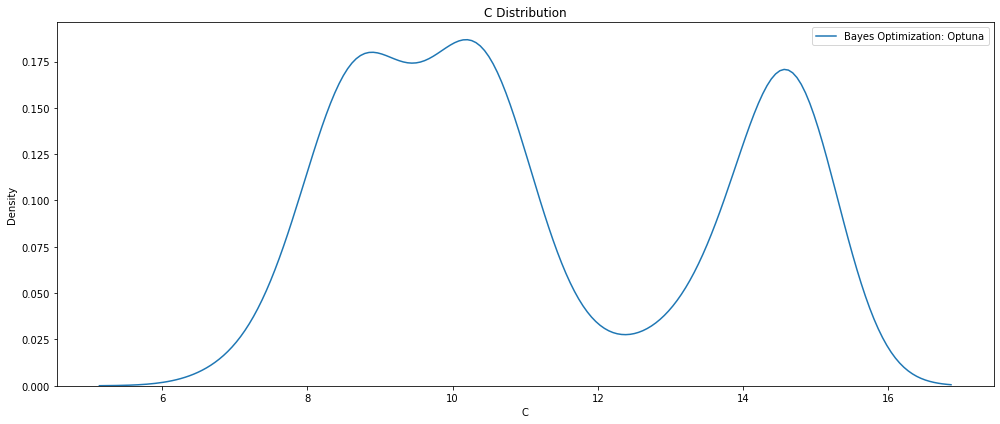

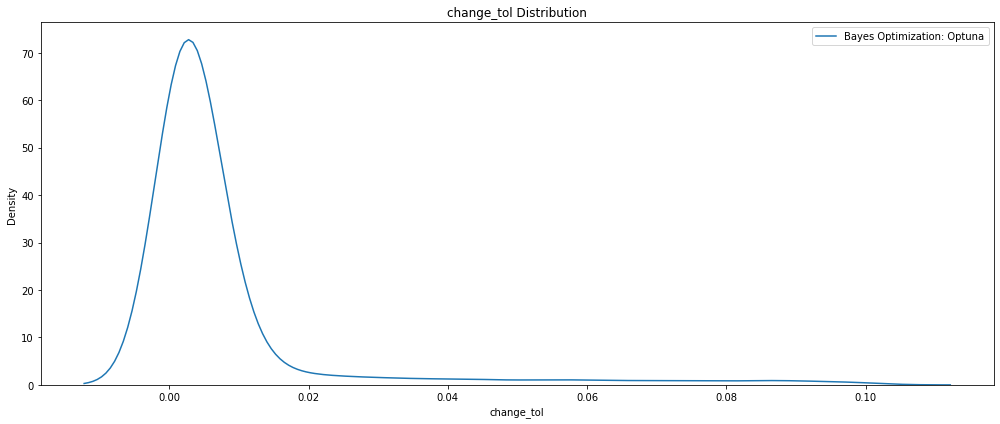

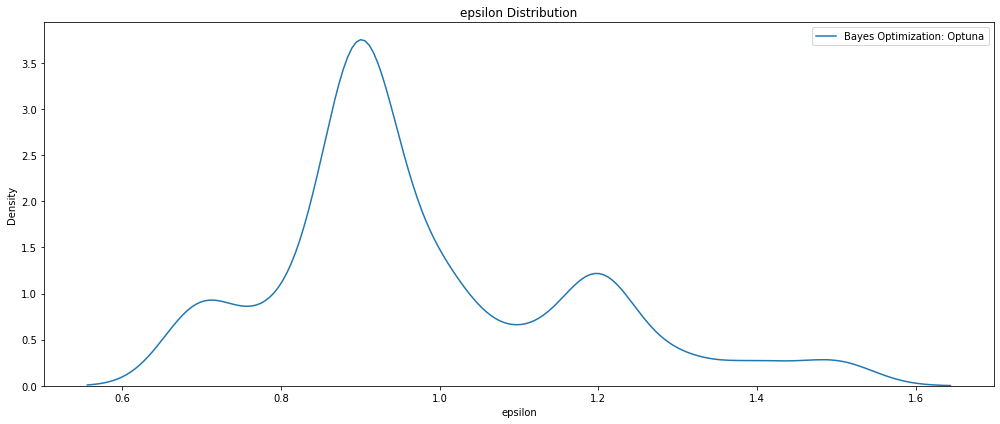

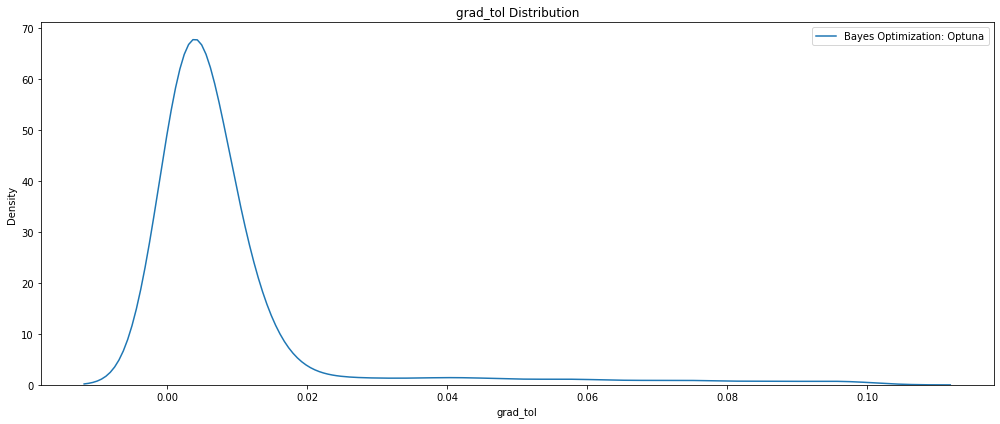

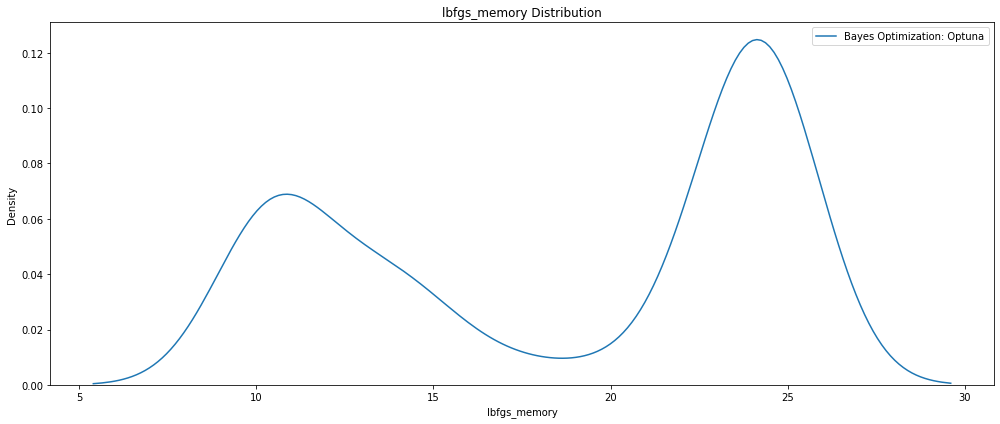

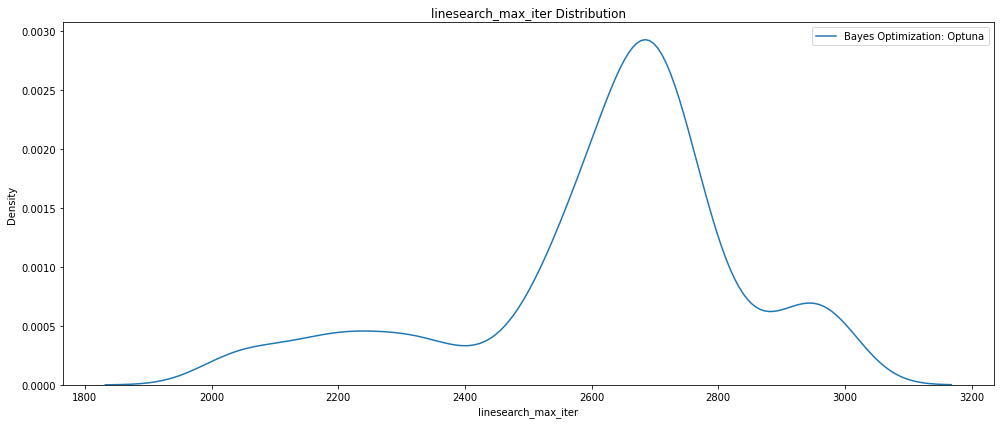

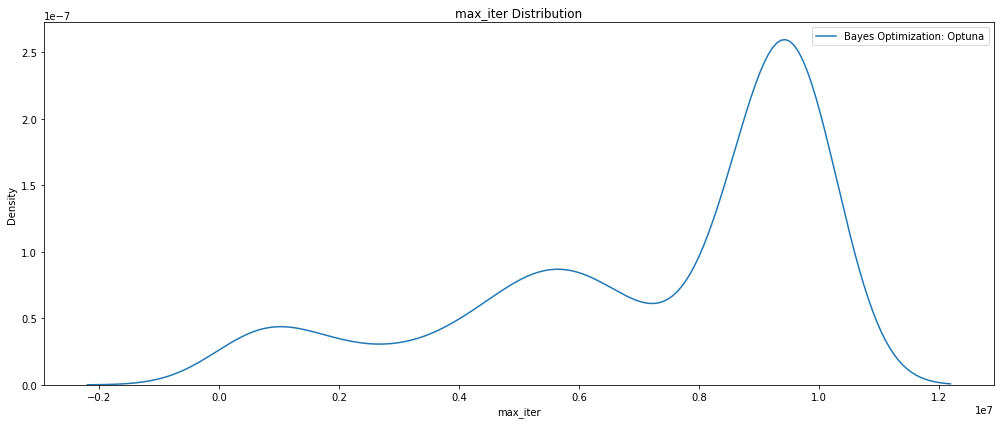

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration', 'loss', 'penatly', 'penalized_intercept', 'state']: 
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

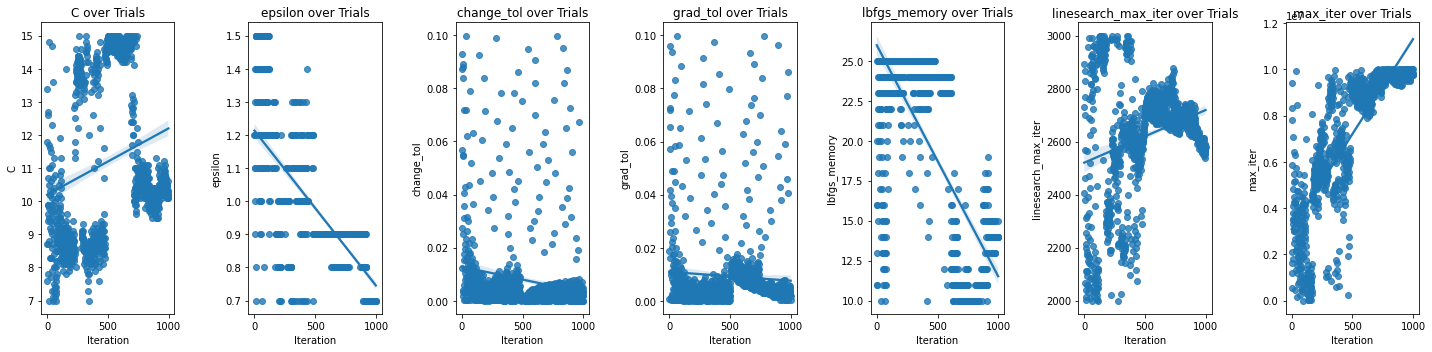

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 7, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['C', 'epsilon', 'change_tol', 
                         'grad_tol', 'lbfgs_memory', 
                         'linesearch_max_iter', 'max_iter']):
  # Scatterplot
  sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
  axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
             title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_LinearSVR_Optuna_1000_GPU.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 10.2,
 'change_tol': 0.00015041222318265283,
 'epsilon': 0.8999999999999999,
 'grad_tol': 0.0036665293622823282,
 'lbfgs_memory': 10,
 'linesearch_max_iter': 2741,
 'max_iter': 9319040,
 'penalty': 'l1'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/Models/ML/LinearSVR/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=seed_value)

In [ ]:
# Create dummy variables and convert data type for modeling
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

X_test = cudf.get_dummies(X_test, columns=cat_cols)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = LinearSVR(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'LinearSVR_Optuna_trials1000_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('LinearSVR_Optuna_trials1000_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for LinearSVR HPO 1000 GPU trials')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_absolute_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy()),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy())))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train.to_numpy(), y_train_pred.to_numpy(), 
                           squared=False),
        mean_squared_error(y_test.to_numpy(), y_test_pred.to_numpy(), 
                           squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train.to_numpy(), y_train_pred.to_numpy()),
        r2_score(y_test.to_numpy(), y_test_pred.to_numpy())))


Model Metrics for LinearSVR HPO 1000 GPU trials
MAE train: 3724.319, test: 3720.107
MSE train: 24099910.000, test: 23963004.000
RMSE train: 4909.166, test: 4895.202
R^2 train: 0.737, test: 0.737


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test.to_numpy(), 
                                                                                                      y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 23963004.00000 MSE on the test set.
This was achieved using these conditions:
iteration                                     766
rmse                                  4895.202148
datetime_start         2022-06-07 01:10:57.030283
datetime_complete      2022-06-07 01:10:58.226573
duration                   0 days 00:00:01.196290
C                                            10.2
change_tol                                0.00015
epsilon                                       0.9
grad_tol                                 0.003667
lbfgs_memory                                   10
linesearch_max_iter                          2741
max_iter                                  9319040
penatly                                        l1
state                                    COMPLETE
Name: 0, dtype: object
